In [759]:
#importacion general de librerias y de visualizacion (matplotlib y seaborn)
%matplotlib notebook
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


#pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


In [760]:
train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')

train_df['location'].fillna(value='sin location', inplace=True)
train_df['keyword'].fillna(value='sin keyword', inplace=True)

train_df['text'] = train_df.text.str.lower()
train_df['text'] = train_df.text.str.replace('%20', ' ')

train_df['keyword'] = train_df.keyword.str.lower()
train_df['keyword'] = train_df.keyword.str.replace('%20', ' ')

train_df['location'] = train_df.location.str.lower()
train_df['location'] = train_df.location.str.replace('%20', ' ')

# Funciones Generales

In [761]:

NOTICIEROS = ['cnn', 'bbc', 'reuters', 'blomberg', 'herald', 'today', 'herald', 'abc', 'fox', 'cbs', \
            'yorker', 'daily', 'financial', 'guardian', 'sun', 'observer', 'five', 'jazeera', 'news', 'live']

PAIS_DESASTRES = ['usa', 'united states', 'canada', 'island', 'japan', 'nigeria', 'turkey', 'saudi', \
                  'malaysia']

CIUDAD_DESASTRES = ['california', 'new york', 'nyc', 'hawaii', 'hiroshima', 'fukushima', 'calgary']
 
DESASTRES_CONOCIDOS = ['mh370', 'air', 'huracan', 'fire', 'water', 'kill', 'disaster', 'suicide', 'police', 'people', \
                      'flood', 'police', 'home', 'family', 'train', 'storm', 'building', 'crash', 'hiroshima', \
                      'bomb', 'isis', 'bombing', 'wreckage', 'earthquake', 'wild', 'wildfire', 'weather', \
                      'violent', 'attack', 'tornado', 'traffic', 'thunder', 'terror', 'suspect', 'swallow',\
                      'sin', 'severe', 'security', 'refugee', 'refugio', 'release', 'report', 'rescue', 'plane',\
                      'passenger', 'offic', 'nuclear', 'north', 'natural', 'national', 'murder', 'migrant', \
                      'mass', 'land', 'issue', 'hurricane', 'injured', 'hostage', 'flood', 'evacua', 'devast']
ZONAS_CONFLICTO = ['israel', 'iran', 'turkey']




CORTE_LENGHT_TEXT = 100

#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred):
    #metrics
    print(classification_report(y_test, y_pred))
    #print(confusion_matrix (y_test, y_pred))

    # Obtener y reformar la matriz de datos de 
    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 


    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)


    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()

# Referencia a un diario o noticiero
def news_ref(text):
    for word in text.split():
        if word in NOTICIEROS:
            return True
    return False

#Categoría ancho mensajes
def text_lenght_category(text):
    if len(text) > CORTE_LENGHT_TEXT:
        return True
    else:
        return False
def desastre_conocido(text):
    for dis in DESASTRES_CONOCIDOS:
        if dis in text:
            return True
    return False

#Pais de desastre
def es_pais_de_desastres(text):
    for word in text.split():
        if word in PAIS_DESASTRES:
            return True
    return False

#Ciudad de desastre
def es_ciudad_de_desastres(text):
    for word in text.split():
        if word in CIUDAD_DESASTRES:
            return True
    return False
def resultados(pred):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)

In [762]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.tag import pos_tag
from textblob import TextBlob

import re, string
from string import punctuation


stops = set(stopwords.words('english'))
punctuation = list(string.punctuation)
#punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]“”^_`{|}~’'


word_list = brown.words()
word_set = set(word_list)

def eliminar_char_espec(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

def sentimiento(text):
    tb = TextBlob(text)
    return tb.sentiment[0]

def unir_texto(text):
    return ( ' '.join(text))

def eliminar_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Elimino stops words 
def eliminar_sw(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stops: 
            pos = pos_tag([i.strip()])
            #word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(i.strip())
    return unir_texto(final_text)

def minusculas(text):
    return text.lower()

def eliminar_nums(text):
    cadena = []
    for x in text:
         if x not in string.digits:
                cadena.append(x)
    return  ''.join(cadena)

def eliminar_punct(text):
    cadena = []
    for x in text:
         if x not in string.punctuation:
                cadena.append(x)
    return  ''.join(cadena)
        
#Generar CSV para el envio
def formatear_texto(text):
    text = minusculas(text)
    text = eliminar_url(text)
    text = eliminar_sw(text)
    text = eliminar_punct(text)
    text = eliminar_nums(text)
    text = eliminar_char_espec(text)
    return text

def cant_err_ortograficos(text):
    cant = 0
    for w in text.split():
        if w not in word_set:
            cant = cant + 1
    return cant
def eliminar_cortas(text):
    cadena = []
    for word in text.split():
        if len(word) > 2:
            cadena.append(word)
    return  ' '.join(cadena)


In [785]:
train_df['text_sin_sw'] = train_df.text.apply(formatear_texto)
train_df['text_sin_sw'] = train_df.text_sin_sw.apply(eliminar_cortas)
train_df['word_count'] = train_df.text.str.split().str.len()
train_df['word_lenght'] = train_df.text.apply(len)
train_df['chars_per_word'] = train_df.word_lenght/train_df.word_count
train_df['cant_err_orto'] =train_df.text_sin_sw.apply(cant_err_ortograficos)
train_df['sentimiento'] = train_df.text.apply(sentimiento)

train_df['http'] = train_df.text.str.contains('http')


train_df['ref_noticias'] = train_df.text_sin_sw.apply(news_ref)

train_df['zona_desastres'] = train_df.text_sin_sw.apply(es_ciudad_de_desastres) |\
                        train_df.text_sin_sw.apply(es_pais_de_desastres)
train_df['desastre_conocido'] = train_df.text_sin_sw.apply(desastre_conocido)


#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)

train_df


,id,keyword,location,text,target,text_sin_sw,word_count,word_lenght,chars_per_word,cant_err_orto,sentimiento,http,ref_noticias,zona_desastres,desastre_conocido
0,1,sin keyword,sin location,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive,13,69,5.3076923077,1,0.0000000000,False,False,False,True
1,4,sin keyword,sin location,forest fire near la ronge sask. canada,1,forest fire near ronge sask canada,7,38,5.4285714286,3,0.1000000000,False,False,True,True
2,5,sin keyword,sin location,all residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,22,133,6.0454545455,0,-0.0187500000,False,False,False,True
3,6,sin keyword,sin location,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,8,65,8.1250000000,2,0.0000000000,False,False,True,True
4,7,sin keyword,sin location,just got sent this photo from ruby #alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,16,88,5.5000000000,3,0.0000000000,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...,11,83,7.5454545455,1,0.0000000000,True,False,False,True
7609,10870,sin keyword,sin location,@aria_ahrary @thetawniest the out of control w...,1,ariaahrary thetawniest control wild fires cali...,20,125,6.2500000000,3,0.1500000000,False,False,True,True
7610,10871,sin keyword,sin location,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,utckm volcano hawaii,8,65,8.1250000000,2,0.0000000000,True,False,True,False
7611,10872,sin keyword,sin location,police investigating after an e-bike collided ...,1,police investigating ebike collided car little...,19,137,7.2105263158,4,-0.2604166667,False,False,False,True


# Datos de entrenamiento

In [764]:
from sklearn.preprocessing import LabelEncoder


#Codificando como categorias
#cat_features = ['ciudad_text', 'ciudad_location', 'pais_text', 'pais_location']
#encoder = LabelEncoder()

# Apliico a cada columna
#encoded = df[cat_features].apply(encoder.fit_transform)


#Datos de entrenameinto
#X = df[['http_hashtag', 'carita_alegre', 'carita_triste', 'length', 'ref_noticias', 'zona_desastres']].join(encoded)

#y = df['target']
#columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
#X = df.drop(columnas, axis=1)




# 1. Random Forest Classifier

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1107
           1       0.73      0.63      0.67       797

    accuracy                           0.75      1904
   macro avg       0.74      0.73      0.73      1904
weighted avg       0.74      0.75      0.74      1904



<IPython.core.display.Javascript object>


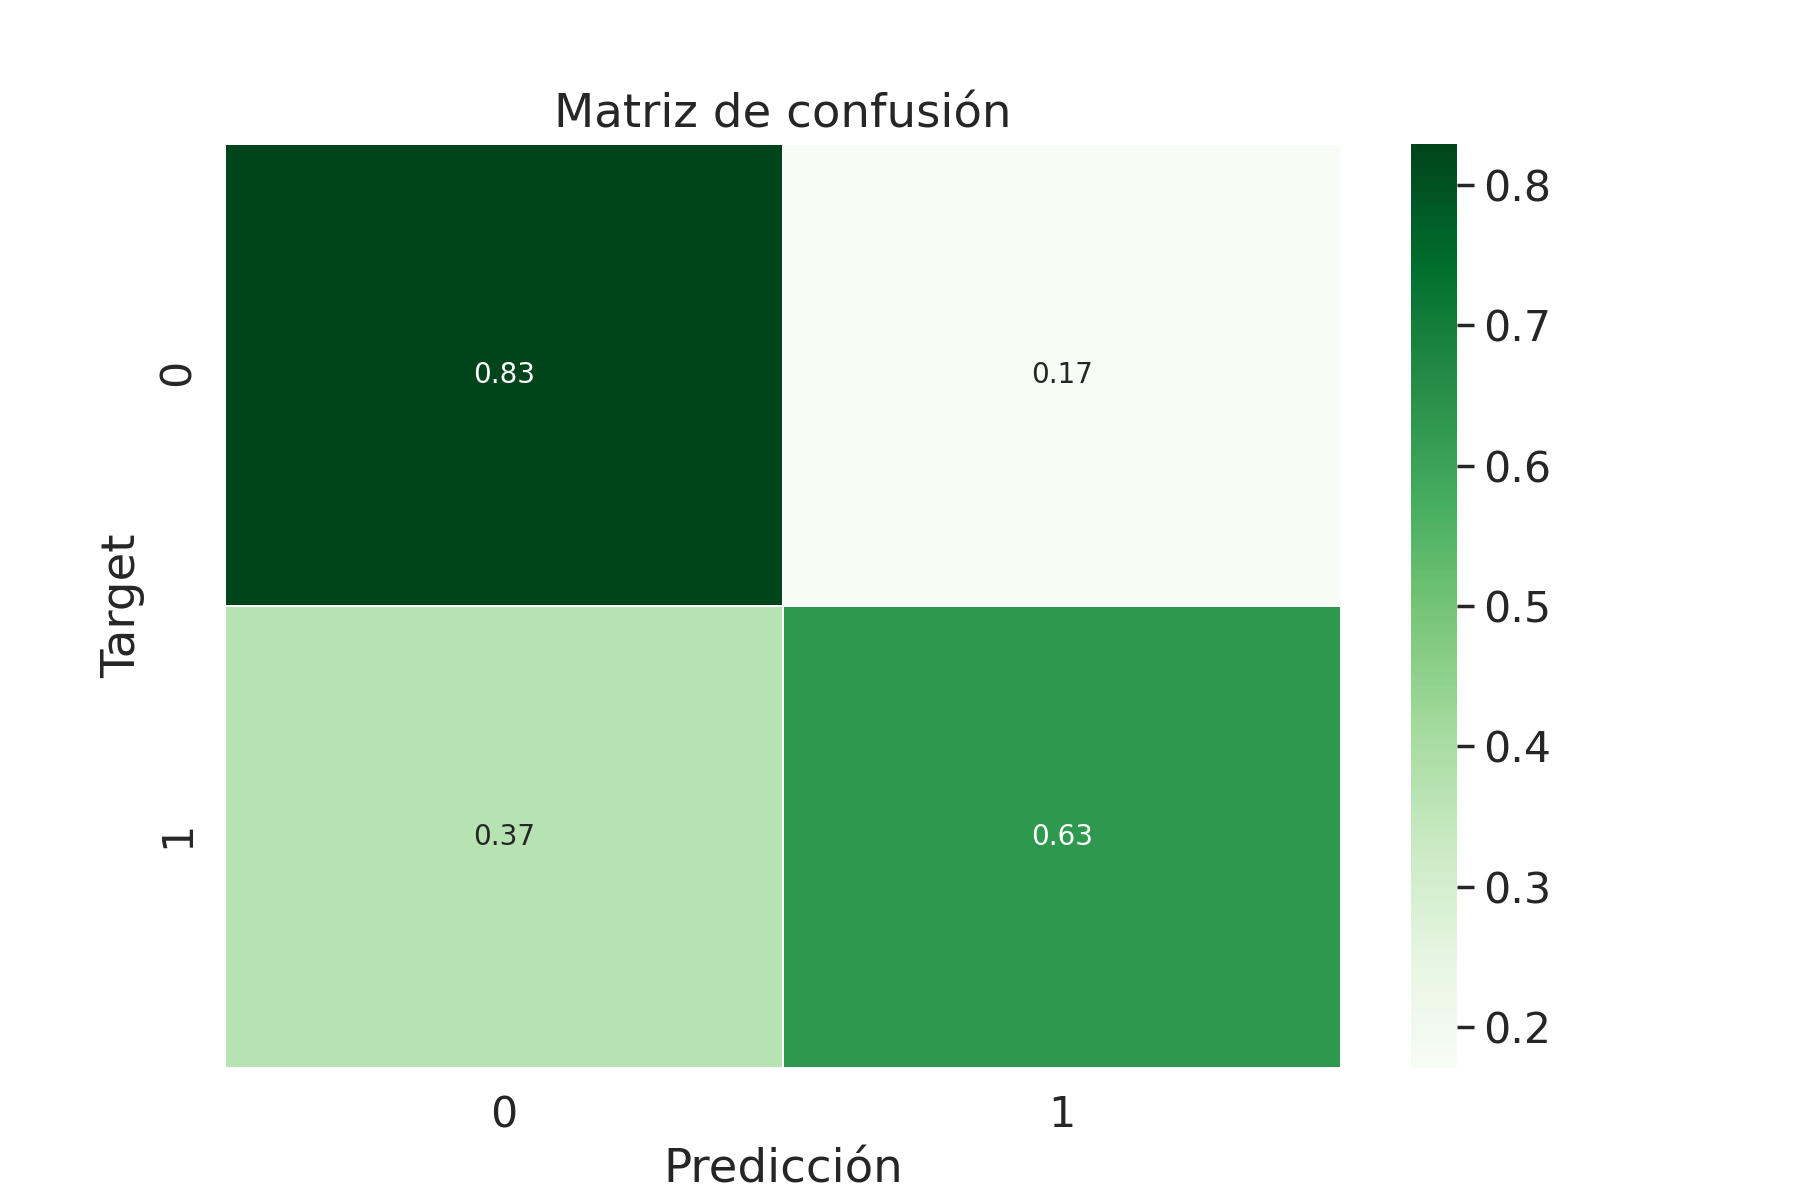

<IPython.core.display.Javascript object>


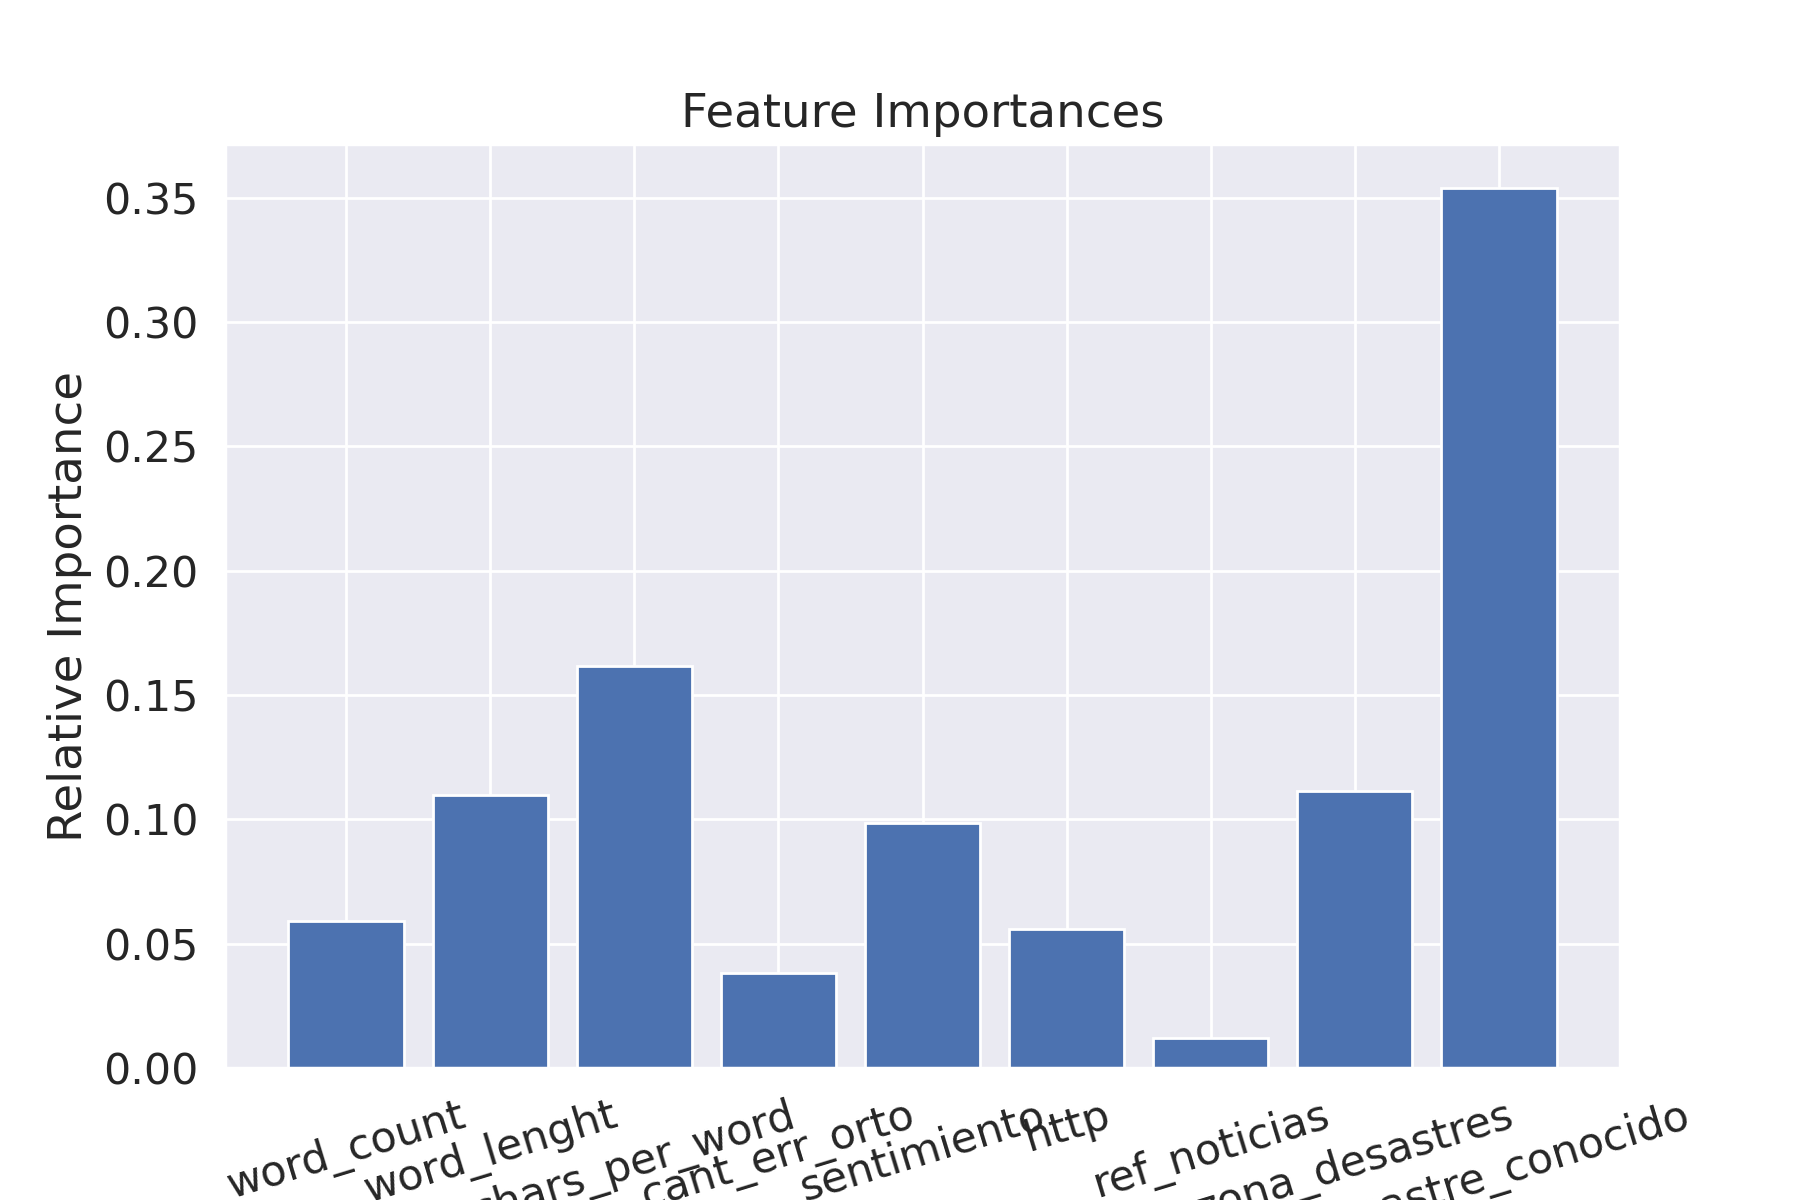

"\n\n#Tree\ntree0 = RFC.estimators_[0]\nfig, axes = plt.subplots(nrows = 1, ncols = 1,  figsize=(9,6), dpi=200)\nplot_tree(tree0, feature_names = X_train.columns, filled = True)\nplt.show()\n\n#Buscando parámetros 'buenos'\nparam_grid = { \n    'n_estimators': [100, 500],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [3, 4,5,6,7,8],\n    'criterion' :['gini', 'entropy']\n}\n\n#Grid Search train\nGSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)\nGSCV.fit(X_train, y_train)\n\n# Best paramns\nprint(GSCV.best_params_)\n\n"

In [786]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

    
y = train_df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
X = train_df.drop(columnas, axis=1)



#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Train
RFC = RandomForestClassifier(n_estimators = 100,  max_depth=8, max_features='auto',
                             criterion='entropy', random_state = 0)

RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#metrics
mostrar_metricas(y_test, y_pred)


#Features
features = np.array(X.columns)
importances = RFC.feature_importances_

#Plot
plt.figure()
plt.bar(X_train.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.xticks(rotation=17)
plt.ylabel('Relative Importance')
plt.show()

'''

#Tree
tree0 = RFC.estimators_[0]
fig, axes = plt.subplots(nrows = 1, ncols = 1,  figsize=(9,6), dpi=200)
plot_tree(tree0, feature_names = X_train.columns, filled = True)
plt.show()

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''


### Random Forest Classifier(TFIDF)

              precision    recall  f1-score   support

           0       0.63      1.00      0.77      1107
           1       1.00      0.17      0.29       797

    accuracy                           0.65      1904
   macro avg       0.81      0.59      0.53      1904
weighted avg       0.78      0.65      0.57      1904



<IPython.core.display.Javascript object>


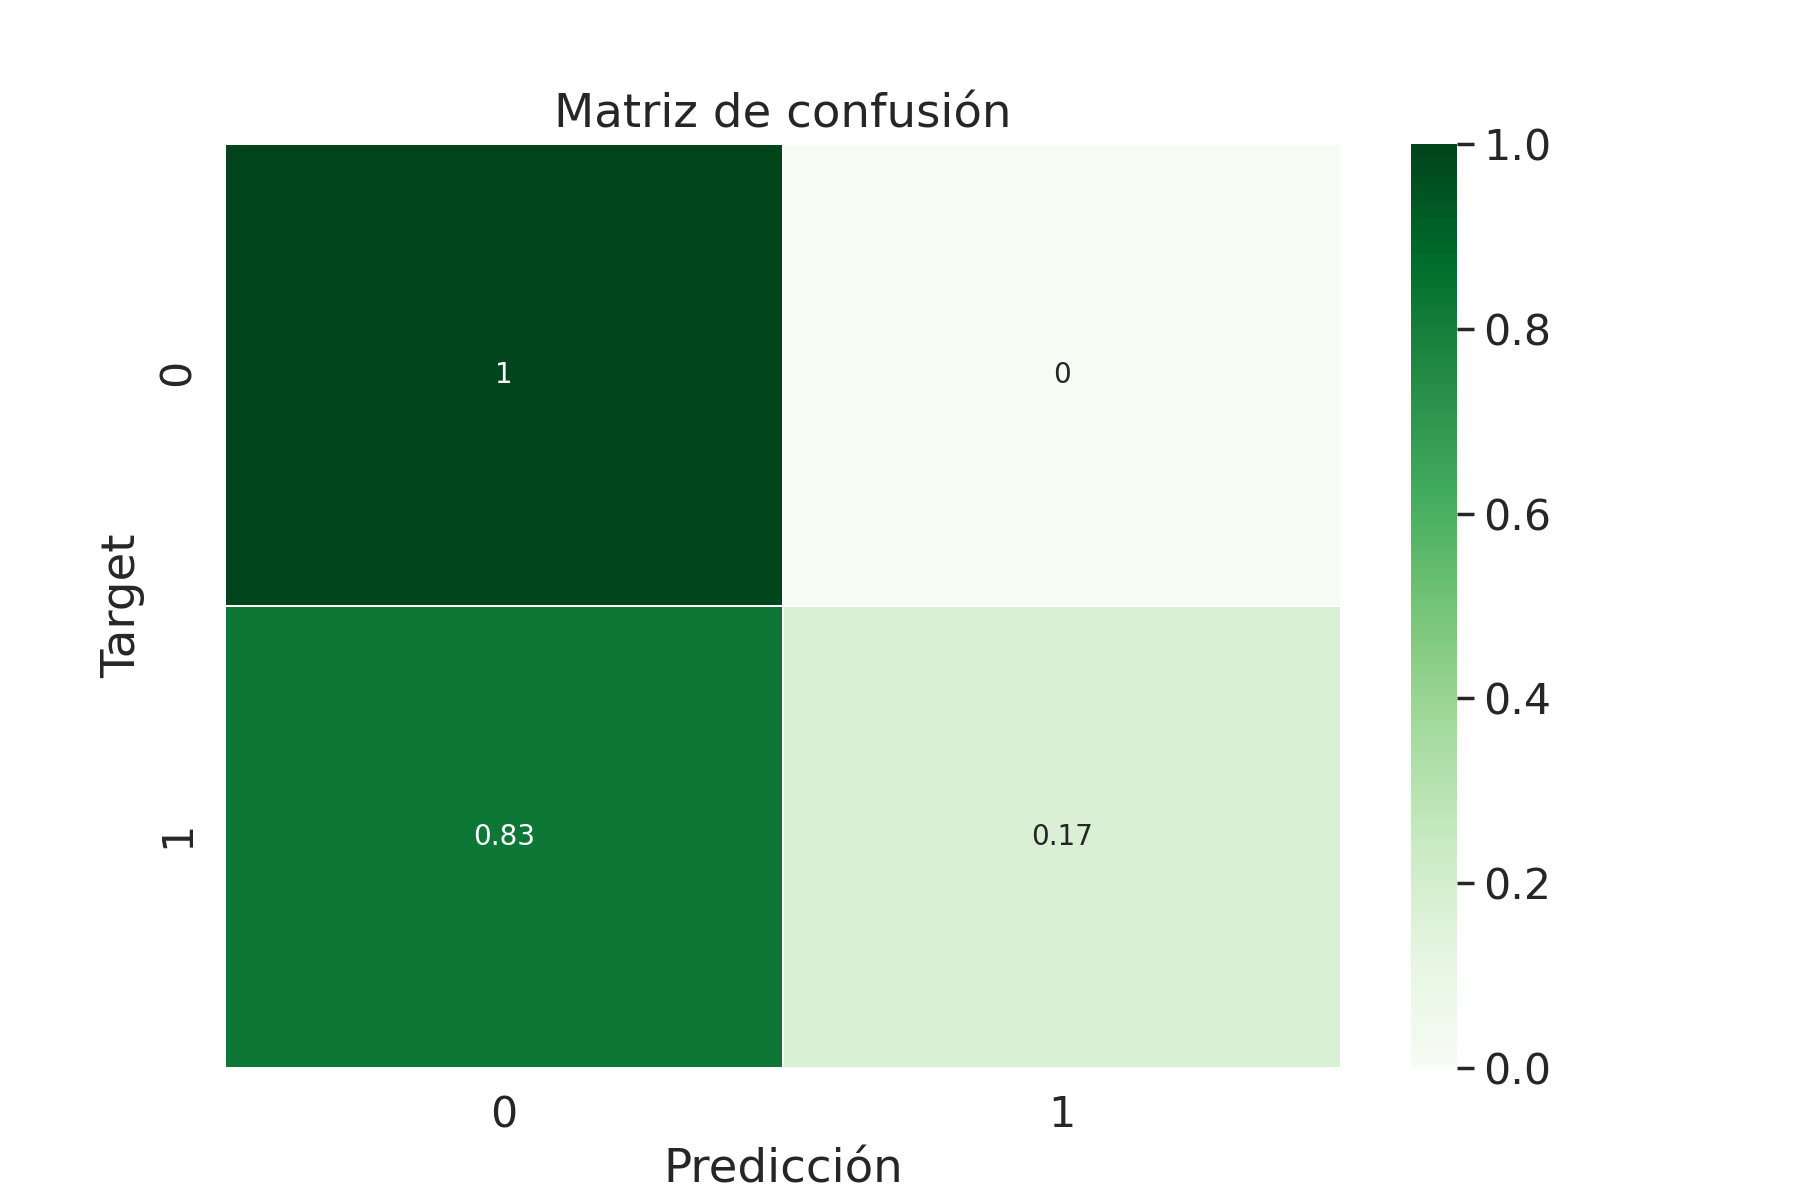

"\n#Buscando parámetros 'buenos'\nparam_grid = { \n    'n_estimators': [100, 600],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [3,5,7,9,11, 13],\n    'criterion' :['gini', 'entropy']\n}\n\n#Grid Search train\nGSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)\nGSCV.fit(X_train, y_train)\n\n# Best paramns\nprint(GSCV.best_params_)\n\n"

In [796]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix

    
X = train_df['text_sin_sw']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
RFC = RandomForestClassifier(n_estimators = 200,  max_depth=11, max_features='auto',
                             criterion='gini', n_jobs=-1, random_state = 17)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

'''
#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11, 13],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''

# 2. Regresión Logística

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1107
           1       0.80      0.68      0.73       797

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



<IPython.core.display.Javascript object>


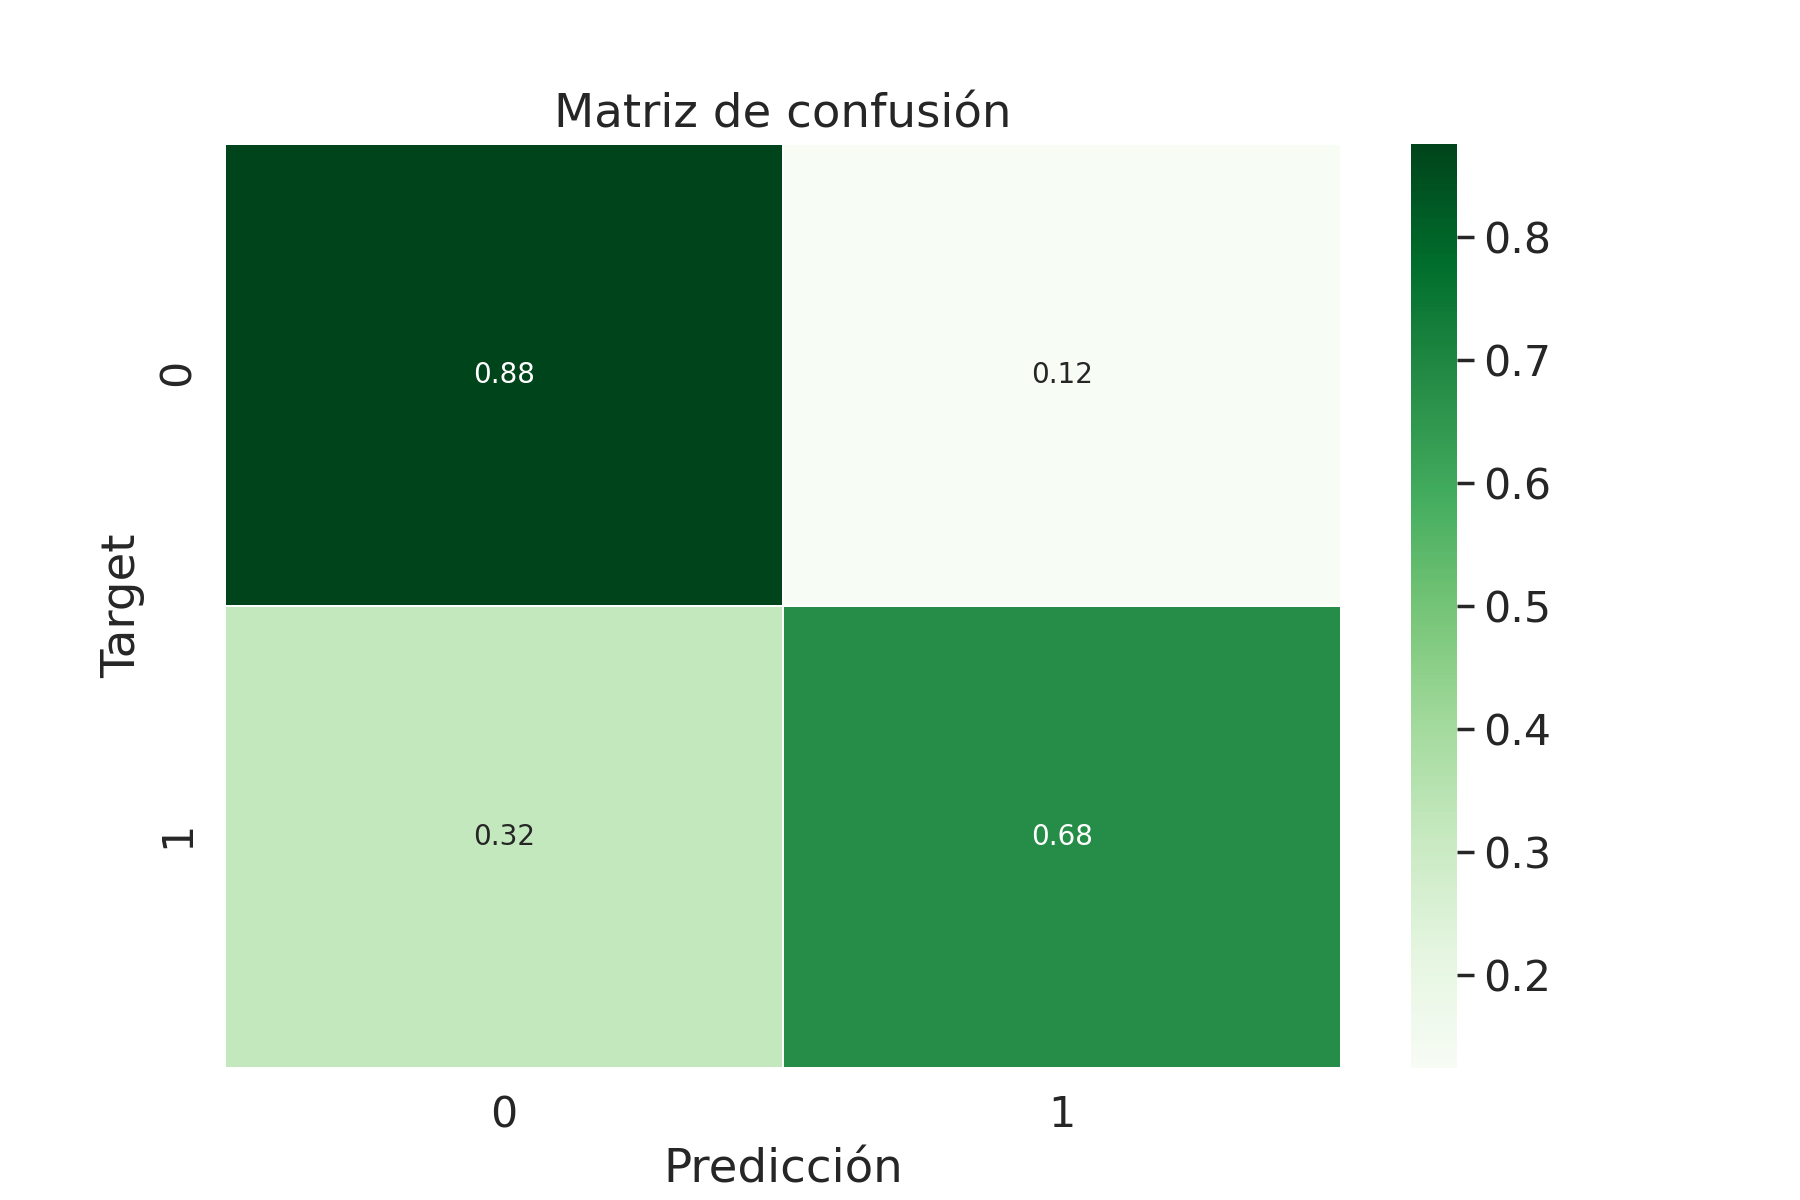

Weight?,Feature
+2.542,hiroshima
+2.024,california
+1.931,wildfire
+1.867,fires
+1.847,killed
+1.793,earthquake
+1.684,derailment
+1.617,massacre
+1.593,evacuated
+1.554,forest


In [794]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import eli5



X = train_df['text_sin_sw']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')


# transform  to a normalized tf-idf representation 
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

LR = LogisticRegression(C=1.5, solver='lbfgs', penalty= 'l2', multi_class='multinomial',
                        random_state=18, n_jobs=4)
#Entrenamiento
LR.fit(X_train, y_train)


#Métricas
y_pred = LR.predict(X_test)
mostrar_metricas(y_test, y_pred)

eli5.show_weights(estimator=LR,feature_names= list(tfidf.get_feature_names()),top=(50, 5))



# 3. KNN

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1107
           1       0.77      0.68      0.72       797

    accuracy                           0.78      1904
   macro avg       0.77      0.76      0.77      1904
weighted avg       0.78      0.78      0.77      1904



<IPython.core.display.Javascript object>


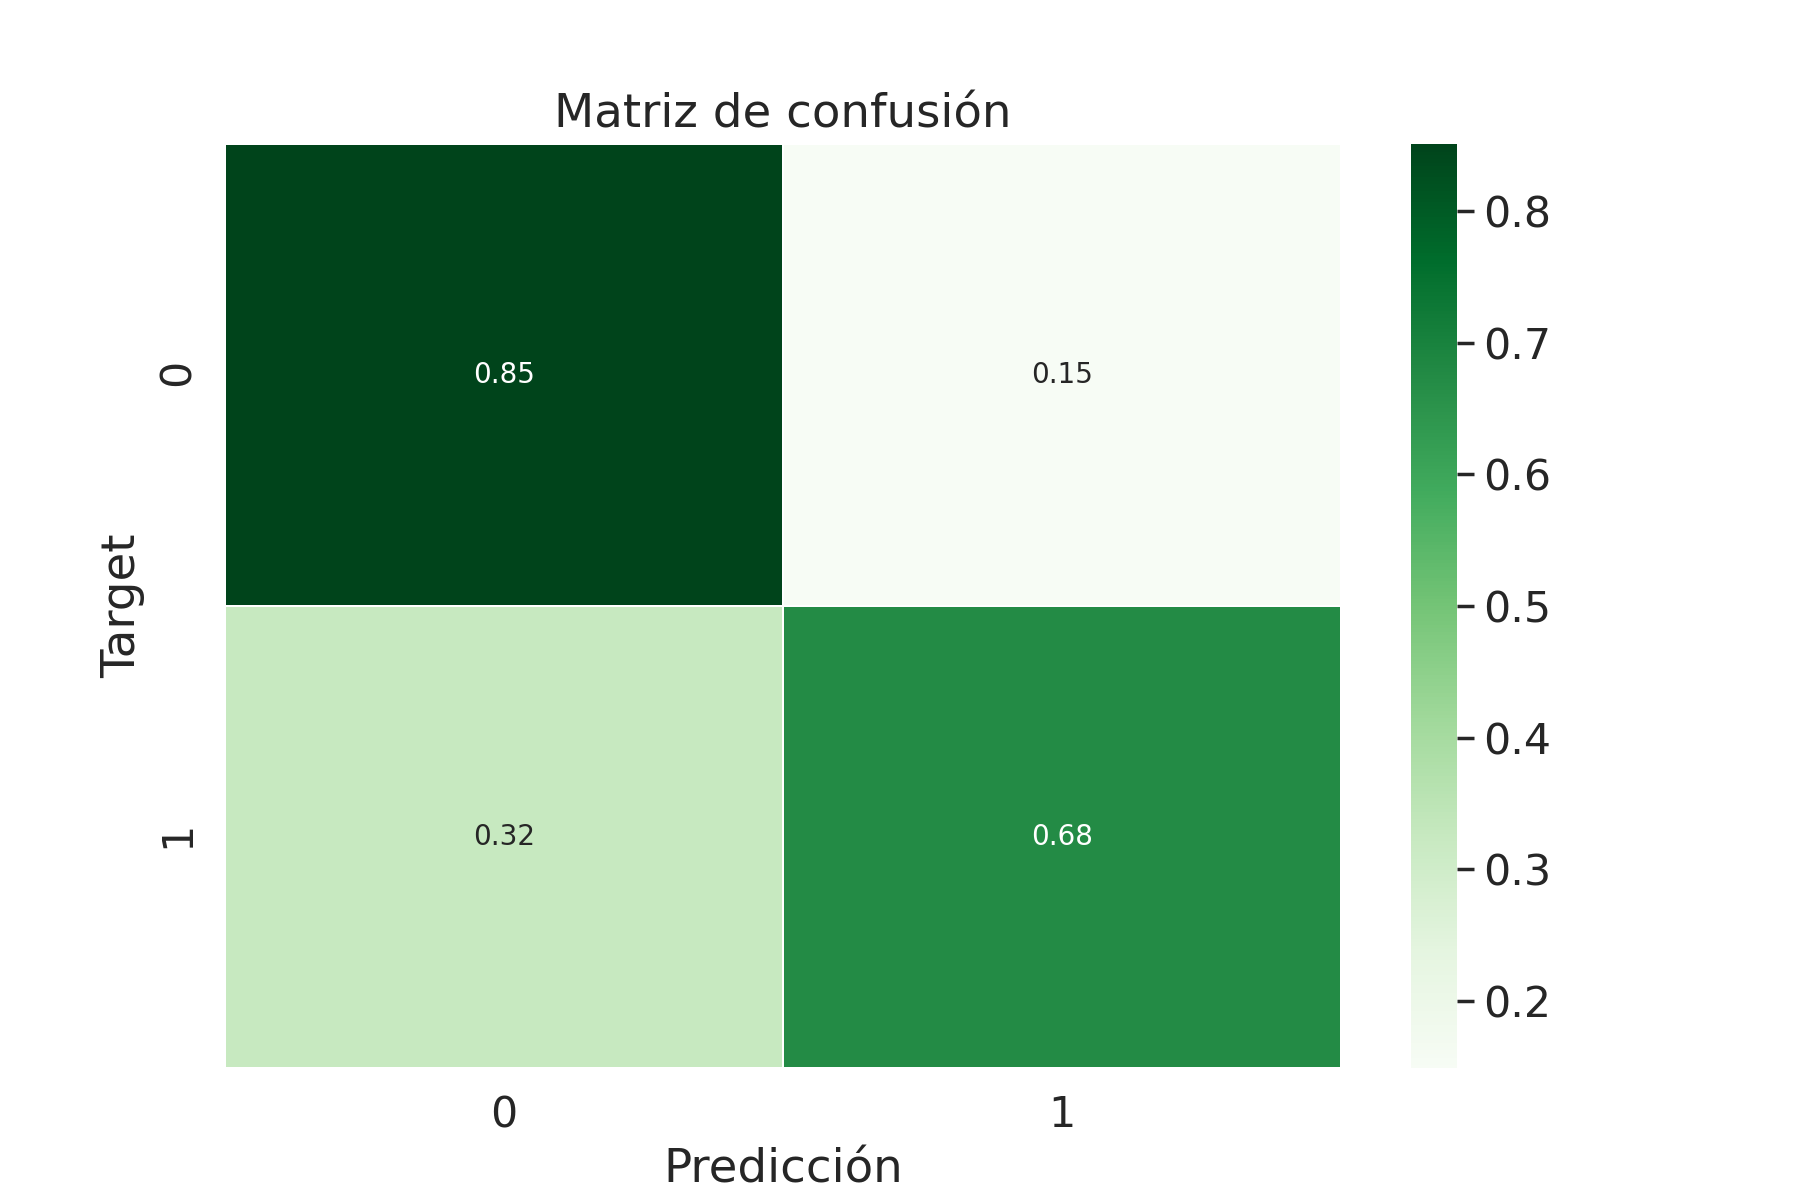

<IPython.core.display.Javascript object>


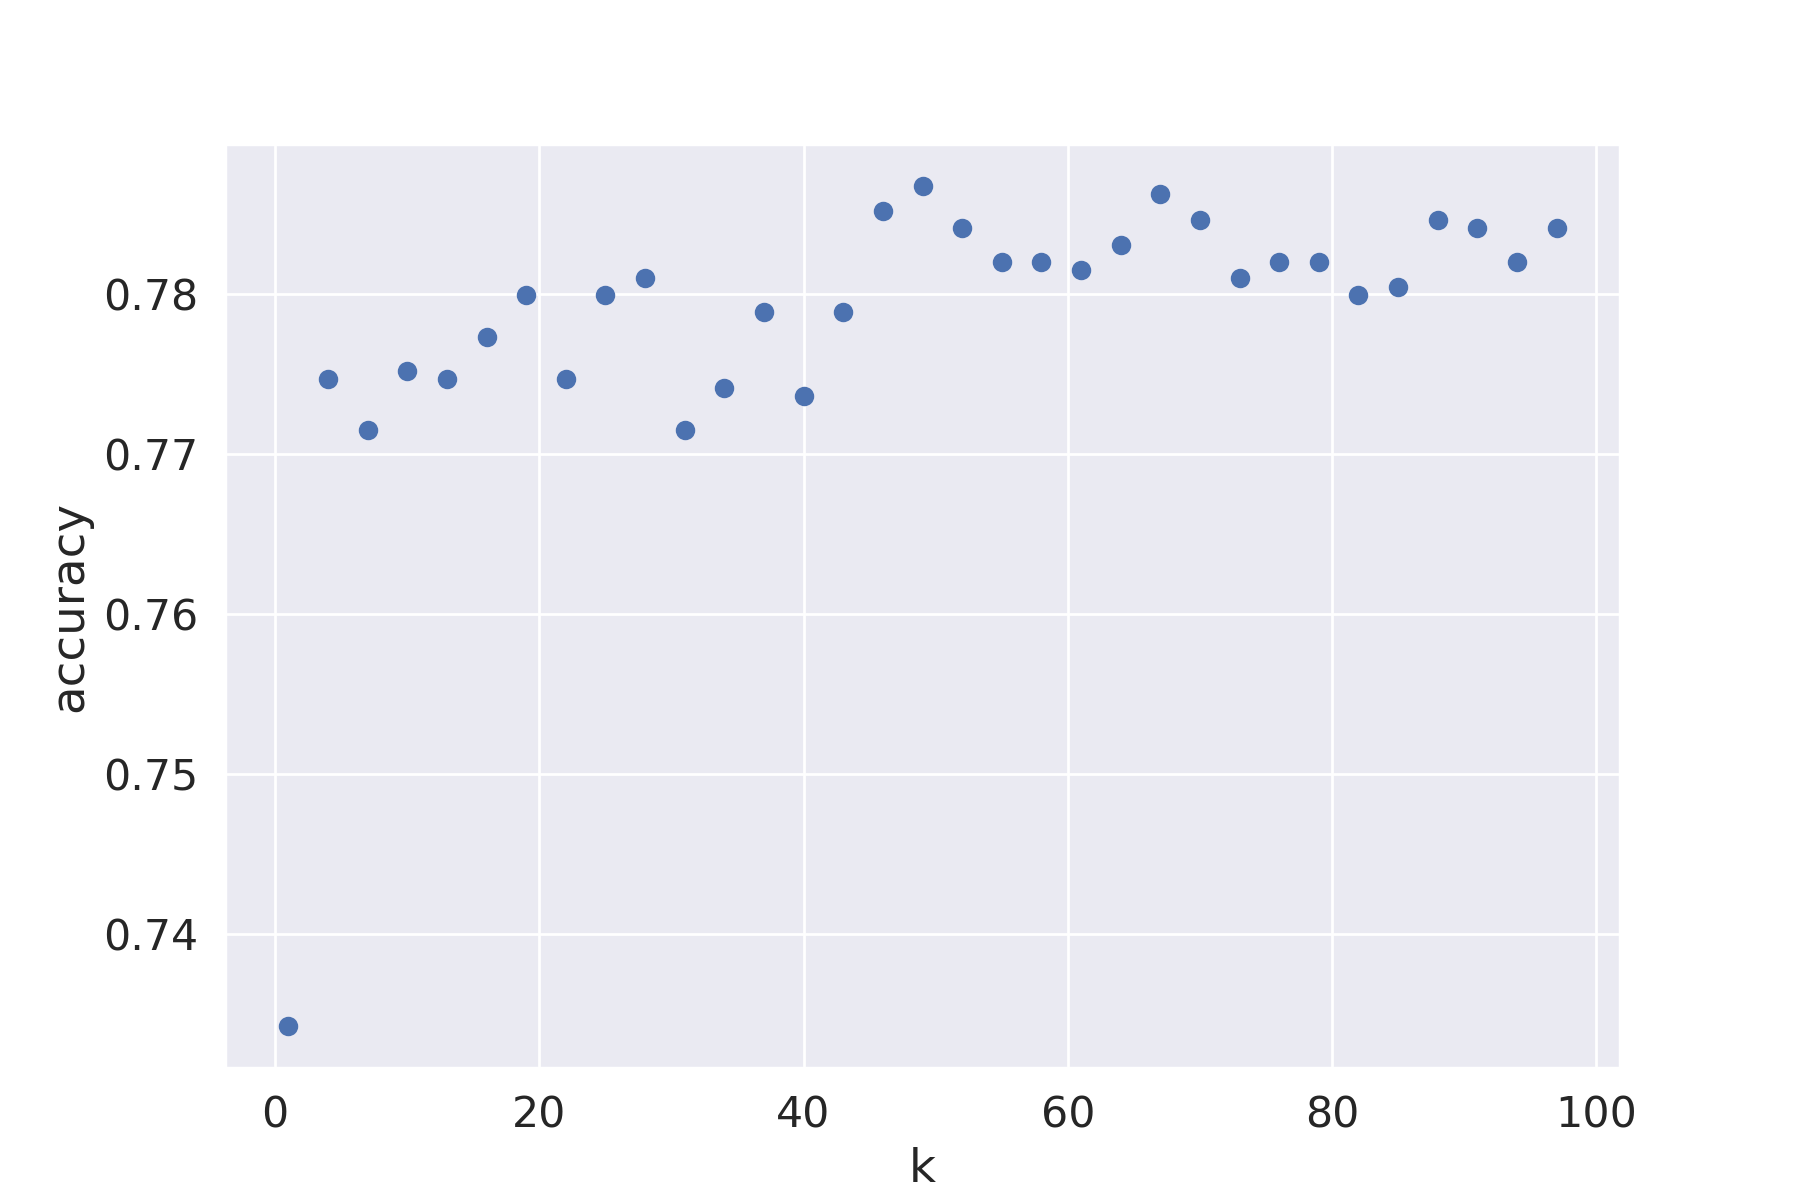

In [768]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

X = train_df['text_sin_sw']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 45)
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
mostrar_metricas(y_test, y_pred)

#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()


# 4. Multinomial NB

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1107
           1       0.77      0.68      0.72       797

    accuracy                           0.78      1904
   macro avg       0.77      0.76      0.77      1904
weighted avg       0.78      0.78      0.77      1904



<IPython.core.display.Javascript object>


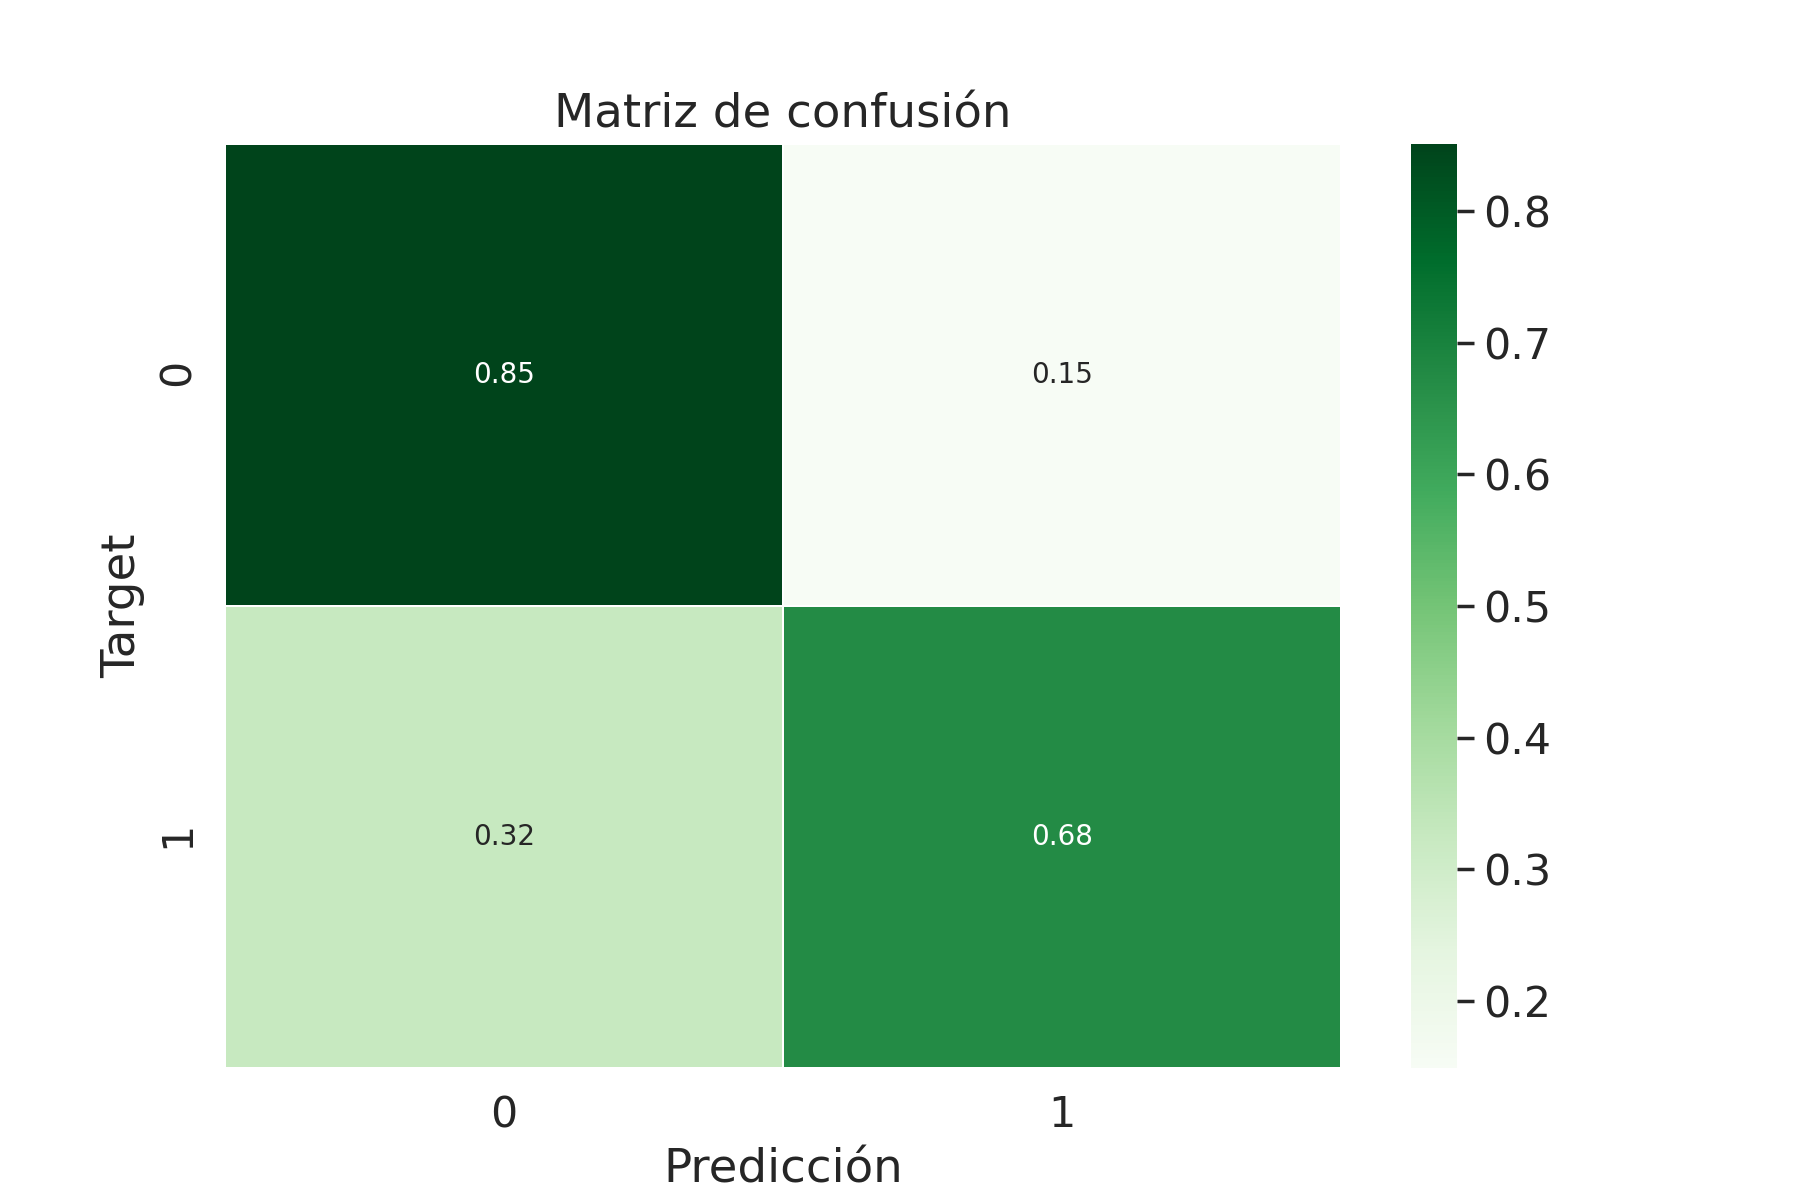

In [769]:
from sklearn.naive_bayes import MultinomialNB

X = train_df['text_sin_sw']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred_gnb = MNB.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)